# DTSA 5510 Unsupervised Algorithms in Machine Learning Final Project

Location of this project: https://github.com/NikoKuu/unsupervised-algorithms-in-ml-final

## Project Topic ##
This work is the final project for DTSA 5510 Unsupervised Algorithms in Machine Learning course. The objective is to demonstrate how to use unsupervised learning methods, including data cleaning and eploratory data analysis (EDA). 

A dataset of Amazon webstore item descriptions was selected from Kaggle by Pavlo Mospan.

Amazon Advertisements, Pavlo Mospan 2019. Available at: https://www.kaggle.com/datasets/sachsene/amazons-advertisements/data. 

The plan is to clean up the data, vectorize the text descriptions of each item and use unsupervised learning methods to categorize the data. The actual categories of each item are known so supervised learning methods can also be used as a comparison to unsupervised.  


## Data ##
The data set consists of 525 csv-files in different levels of categories. There are 22 main categories and up to three deeper categories. The main focus of this work is to cluster the items based on the desription text mainly focusing on the main category. 

Some of the text descriptions are very short and frankly impossible to categorize, such as a one-word description with the product number. The text data also has a lot of numerical values for dimensions or quantity. A few methods to handle the numerical values was experimented. 

## Data Cleaning ##

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, RocCurveDisplay, roc_auc_score
%matplotlib inline



In [2]:
datafile = r'..\Amazon Ads\data\sports-outdoors\fitness\team-sports\amazon_fitness_team-sports_tennis.csv'
with open(u'\\\\?\\' + os.path.abspath(datafile), 'r', encoding="utf8") as f:
    lines = f.read().splitlines() # without the \n in the end 
df = pd.DataFrame(lines[1:], columns=['description'])
placeholder = '<NUM>'
# pd.read_table
print(df['description'][0])
desc = re.sub(r'\d+', placeholder, df['description'][0])
print(desc)


Tourna Mesh Carry Bag of 18 Tennis Balls
Tourna Mesh Carry Bag of <NUM> Tennis Balls


#### Collect data

In [3]:
class amz_data:
    def __init__(self):
        self.id = 0
        self.df = pd.DataFrame()
        self.df_cat = pd.DataFrame(columns=['main', 'sub', 'subsub', 'bottom'])
        self.placeholder = '<NUM>'

    def add_to_dataframe(self, path):
        # print(path)
        # Too long path name. Needed to add the prefix for long path names.
        with open(u'\\\\?\\' + os.path.abspath(path), 'r', encoding="utf8") as f:
            # lines = f.readlines()
            lines = f.read().splitlines() # without the \n in the end 
        df = pd.DataFrame(lines[1:], columns=['description'])
        df['id'] = self.id # Assign a unique id
        df['word_count'] = df.apply(self.count_words, axis=1)
        df['description'] = df.apply(self.replace_numbers, axis=1)
        categories = list(self.get_category(os.path.basename(path)))
        df['main'] =  categories[0]
        df['sub'] =  categories[1]
        df['subsub'] =  categories[2]
        df['bottom'] =  categories[3]
        self.df = pd.concat([self.df, df], ignore_index=True)
        # self.df_cat = pd.concat([self.df_cat, [self.id, self.get_category(os.path.basename(path))]], ignore_index=True)
        self.df_cat.loc[len(self.df_cat)] = list(self.get_category(os.path.basename(path)))
        self.id = self.id + 1

    def read_data(self, basedir):
         # https://docs.python.org/3.9/library/os.html?highlight=os%20walk
        for root, dirs, files in os.walk(basedir):
            #print(files)
            for file in files:
                path = os.path.join(root, file)
                self.add_to_dataframe(path)
    
    def get_category(self, file_name):
        category = file_name.split('.')[0]
        cat_list = category.split('_')
        cat_list = [s.replace('-', ' ') for s in cat_list]
        main = cat_list[1]
        if len(cat_list) >= 4:
            sub = cat_list[2]
        else:
            sub = None
        if len(cat_list) >= 5:
            subsub = cat_list[3]
        else: 
            subsub = None
        bottom = cat_list[-1]
        return main, sub, subsub, bottom
    
    def count_words(self, row):
        words = len(row['description'].split(' '))
        return words
    
    def replace_numbers(self, row):
        text = re.sub(r'\d+', self.placeholder, row['description'])
        return text


# datafile = r'..\Datasets\Amazon Advertisements\scrapped_data\arts_crafts\amazon_arts_crafts_common.csv'
# df = pd.read_csv(datafile)

amz = amz_data()
amz.read_data(r'..\Amazon Ads\data')




In [4]:
def get_category(file_name):
    category = file_name.split('.')[0]
    cat_list = category.split('_')
    cat_list = [s.replace('-', ' ') for s in cat_list]
    main = cat_list[1]
    if len(cat_list) >= 4:
        sub = cat_list[2]
    else:
        sub = ''
    if len(cat_list) >= 5:
        subsub = cat_list[3]
    else: 
        subsub = ''
    bottom = cat_list[-1]
    return main, sub, subsub, bottom

file = 'amazon_aports-outdoors_recreation_water-sports_paddleboarding.csv'
print(get_category(file))
file = 'amazon_smart-home.csv'
print(get_category(file))


('aports outdoors', 'recreation', 'water sports', 'paddleboarding')
('smart home', '', '', 'smart home')


### Dataset info ###

First, a general info is printed out. The dataframe has over three million entries an

In [5]:
print(amz.df.info(),'\n')
print(amz.df.head(),'\n')
print('\nNumber of nan values:\n', np.sum(amz.df.isna())),'\n'
print('\nNumber of duplicated entries:', np.sum(amz.df.duplicated()))
print('Drop duplicates')
amz.df.drop_duplicates(inplace=True)
print('Number of duplicated entries:', np.sum(amz.df.duplicated()))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3318260 entries, 0 to 3318259
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   description  object
 1   id           int64 
 2   word_count   int64 
 3   main         object
 4   sub          object
 5   subsub       object
 6   bottom       object
dtypes: int64(2), object(5)
memory usage: 177.2+ MB
None 

                                         description  id  word_count  \
0  Hisense <NUM>-Inch <NUM>K Ultra HD Smart LED T...   0          10   
1  VIZIO <NUM> Inches <NUM>K Ultra HD Smart LED T...   0          11   
2  "Sony XBR<NUM>X<NUM>E-Series <NUM>""-Class HDR...   0           8   
3  "TiVo BOLT VOX <NUM>TB, DVR & Streaming Media ...   0          17   
4  Sharp <NUM>-Inch <NUM>K Smart LED TV LC-<NUM>Q...   0           8   

         main   sub subsub      bottom  
0  smart home  None   None  smart home  
1  smart home  None   None  smart home  
2  smart home  None   None  smart home  
3  smar

C:\Users\nikok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)



Number of nan values:
 description          0
id                   0
word_count           0
main                 0
sub            1102617
subsub         3123298
bottom               0
dtype: int64

Number of duplicated entries: 317863
Drop duplicates
Number of duplicated entries: 0


In [6]:
print(amz.df_cat.info(), '\n')
print('Duplicated entries:', np.any(amz.df_cat.duplicated()), '\n')
print('Number of main categories:', len(pd.unique(amz.df_cat['main'])))
print('Number of sub-categories:', len(pd.unique(amz.df_cat['sub'])))
print('Number of lower sub-categories:', len(pd.unique(amz.df_cat['subsub'])))
print('Number of most detailed categories:', len(pd.unique(amz.df_cat['bottom'])))

<class 'pandas.core.frame.DataFrame'>
Index: 525 entries, 0 to 524
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   main    525 non-null    object
 1   sub     366 non-null    object
 2   subsub  47 non-null     object
 3   bottom  525 non-null    object
dtypes: object(4)
memory usage: 20.5+ KB
None 

Duplicated entries: False 

Number of main categories: 22
Number of sub-categories: 28
Number of lower sub-categories: 11
Number of most detailed categories: 439


## Exploratory Data Analysis ##

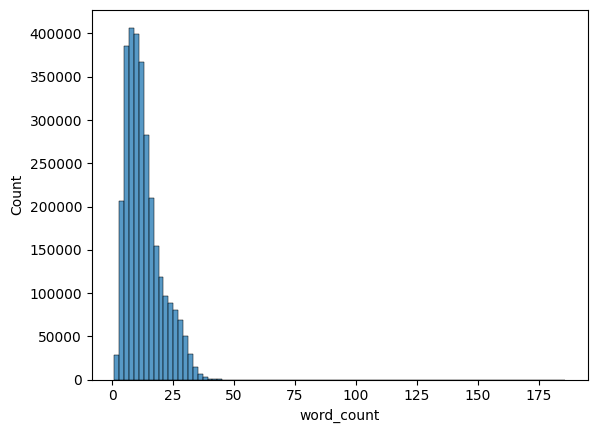

Maximum number of words: 186
Minimum number of words: 1
Entry with the minimum amount of words:
 description    B<NUM>XPP<NUM>WJZ
id                             0
word_count                     1
main                  smart home
sub                         None
subsub                      None
bottom                smart home
Name: 799, dtype: object


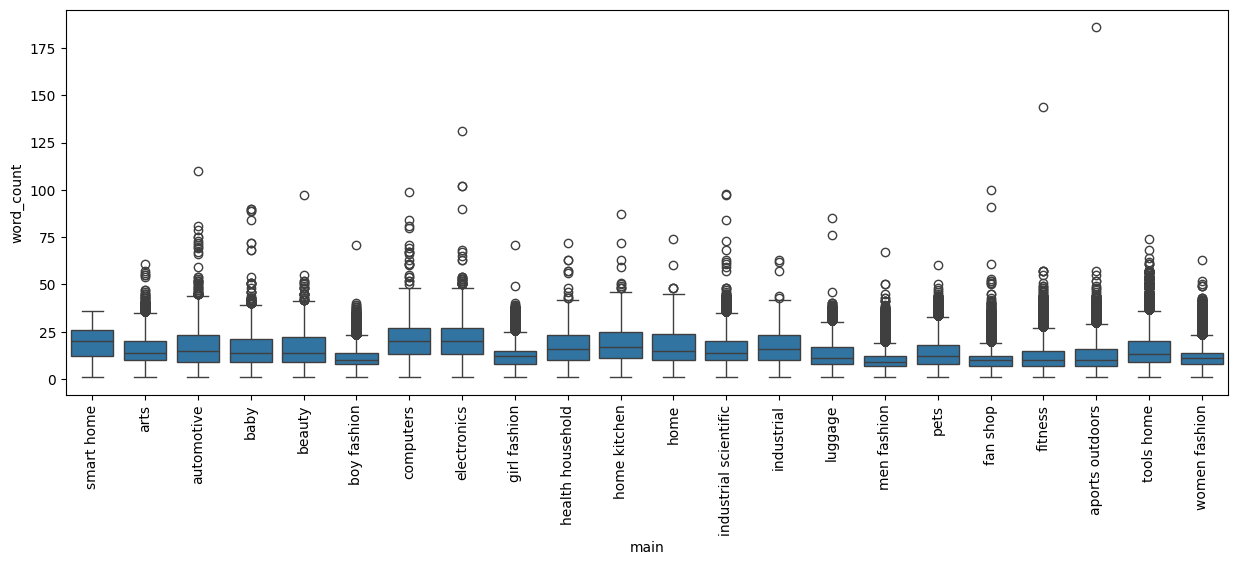

In [7]:
sns.histplot(amz.df, x='word_count', binwidth=2)
plt.show()
print('Maximum number of words:', max(amz.df['word_count']))
print('Minimum number of words:', min(amz.df['word_count']))
print('Entry with the minimum amount of words:\n', amz.df.iloc[np.argmin(amz.df['word_count'])])

fig = plt.figure(figsize=(15, 5))
sns.boxplot(amz.df, x='main', y='word_count')
plt.xticks(rotation=90, fontsize = 10) 
plt.show()


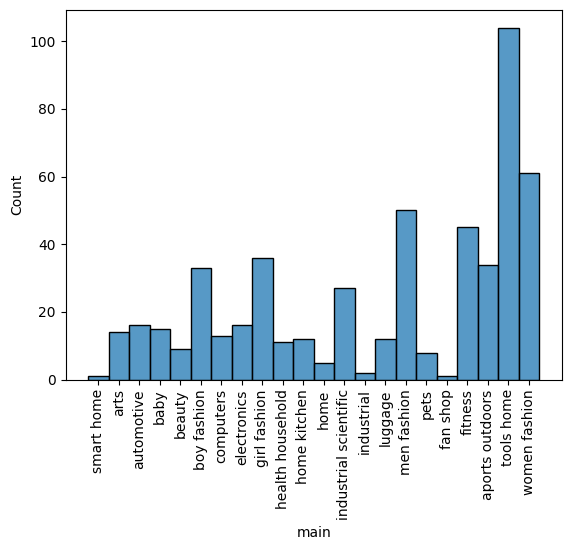

In [8]:
sns.histplot(amz.df_cat, x='main', binwidth=2)
plt.xticks(rotation=90, fontsize = 10) 
plt.show()

In [9]:
print(amz.df.loc[799])

description    B<NUM>XPP<NUM>WJZ
id                             0
word_count                     1
main                  smart home
sub                         None
subsub                      None
bottom                smart home
Name: 799, dtype: object


### Tokenization


In [10]:
my_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words="english", max_features=10000)
mat = my_vectorizer.fit_transform(amz.df['description'])
mat.shape


(3000397, 10000)

In [11]:
Y_train = amz.df['main']

print('Shape of the matrix:', mat.shape)
ftr_names = my_vectorizer.get_feature_names_out()
print('Length of ftr_names:',len(ftr_names))
print('ftr_names:', my_vectorizer.get_feature_names_out())

Shape of the matrix: (3000397, 10000)
Length of ftr_names: 10000
ftr_names: ['aa' 'aa num' 'aaa' ... 'zoo med' 'zoom' 'zoomable']


## Models ##


### Helper functions ###

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, RocCurveDisplay, roc_auc_score

class calc_metrics:
    def __init__(self, y_test, y_pred):
        self.confusion_matrix = None
        self.recall = None
        self.f1_score = None
        self.precision = None
        self.recall = None
        self.FNR = None

        self.get_metrics(y_test, y_pred)

    def get_metrics(self, y_test, y_pred):
        conf_mat = confusion_matrix(y_test, y_pred, labels=[0,1])
        self.confusion_matrix = pd.DataFrame(conf_mat)
        self.accuracy = accuracy_score(y_test, y_pred)
        self.f1_score = f1_score(y_test, y_pred)
        self.precision = precision_score(y_test, y_pred)
        self.recall = recall_score(y_test, y_pred)
        self.ROC_AUC = roc_auc_score(y_test, y_pred)
        FN = conf_mat[1][0]
        P = np.sum(conf_mat[1])
        self.FNR = FN/P
        print('False Negative Rate:', round(self.FNR,3))
        print('Accuracy:', round(self.accuracy, 3))
        print('F1-score:', round(self.f1_score,3))
        print('Precision:', round(self.precision,3))
        print('Recall:', round(self.recall,3))
        print('Area Under the Receiver Operating Characteristic Curve (ROC AUC):', round(self.ROC_AUC,3))
        print('Confusion matrix:')
        disp = ConfusionMatrixDisplay(conf_mat)
        disp.plot()
        plt.show()

In [13]:
myNMF = NMF(n_components=22, solver='cd', beta_loss='frobenius',alpha_W=0.0001, alpha_H='same')

W = myNMF.fit_transform(mat)
H = myNMF.components_

# W_test = myNMF.transform(X_test)
# print('Shape of W_test:', W_test.shape)

In [14]:
print('Shape of the matrix:', mat.shape)
print('Shape of W:', W.shape)
print('The first row of W:', W[0,:])
print('Shape of H:', H.shape)
print('The first column of H:', H[:,0])

Shape of the matrix: (3000397, 10000)
Shape of W: (3000397, 22)
The first row of W: [0.05583757 0.         0.         0.         0.         0.
 0.11692424 0.         0.         0.         0.         0.04097147
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Shape of H: (22, 10000)
The first column of H: [0.00704394 0.         0.00166333 0.         0.         0.00271992
 0.         0.         0.         0.         0.         0.01733213
 0.00306878 0.         0.         0.         0.         0.00149702
 0.00063756 0.         0.         0.        ]


Main categories: ['smart home' 'arts' 'automotive' 'baby' 'beauty' 'boy fashion'
 'computers' 'electronics' 'girl fashion' 'health household'
 'home kitchen' 'home' 'industrial scientific' 'industrial' 'luggage'
 'men fashion' 'pets' 'fan shop' 'fitness' 'aports outdoors' 'tools home'
 'women fashion']


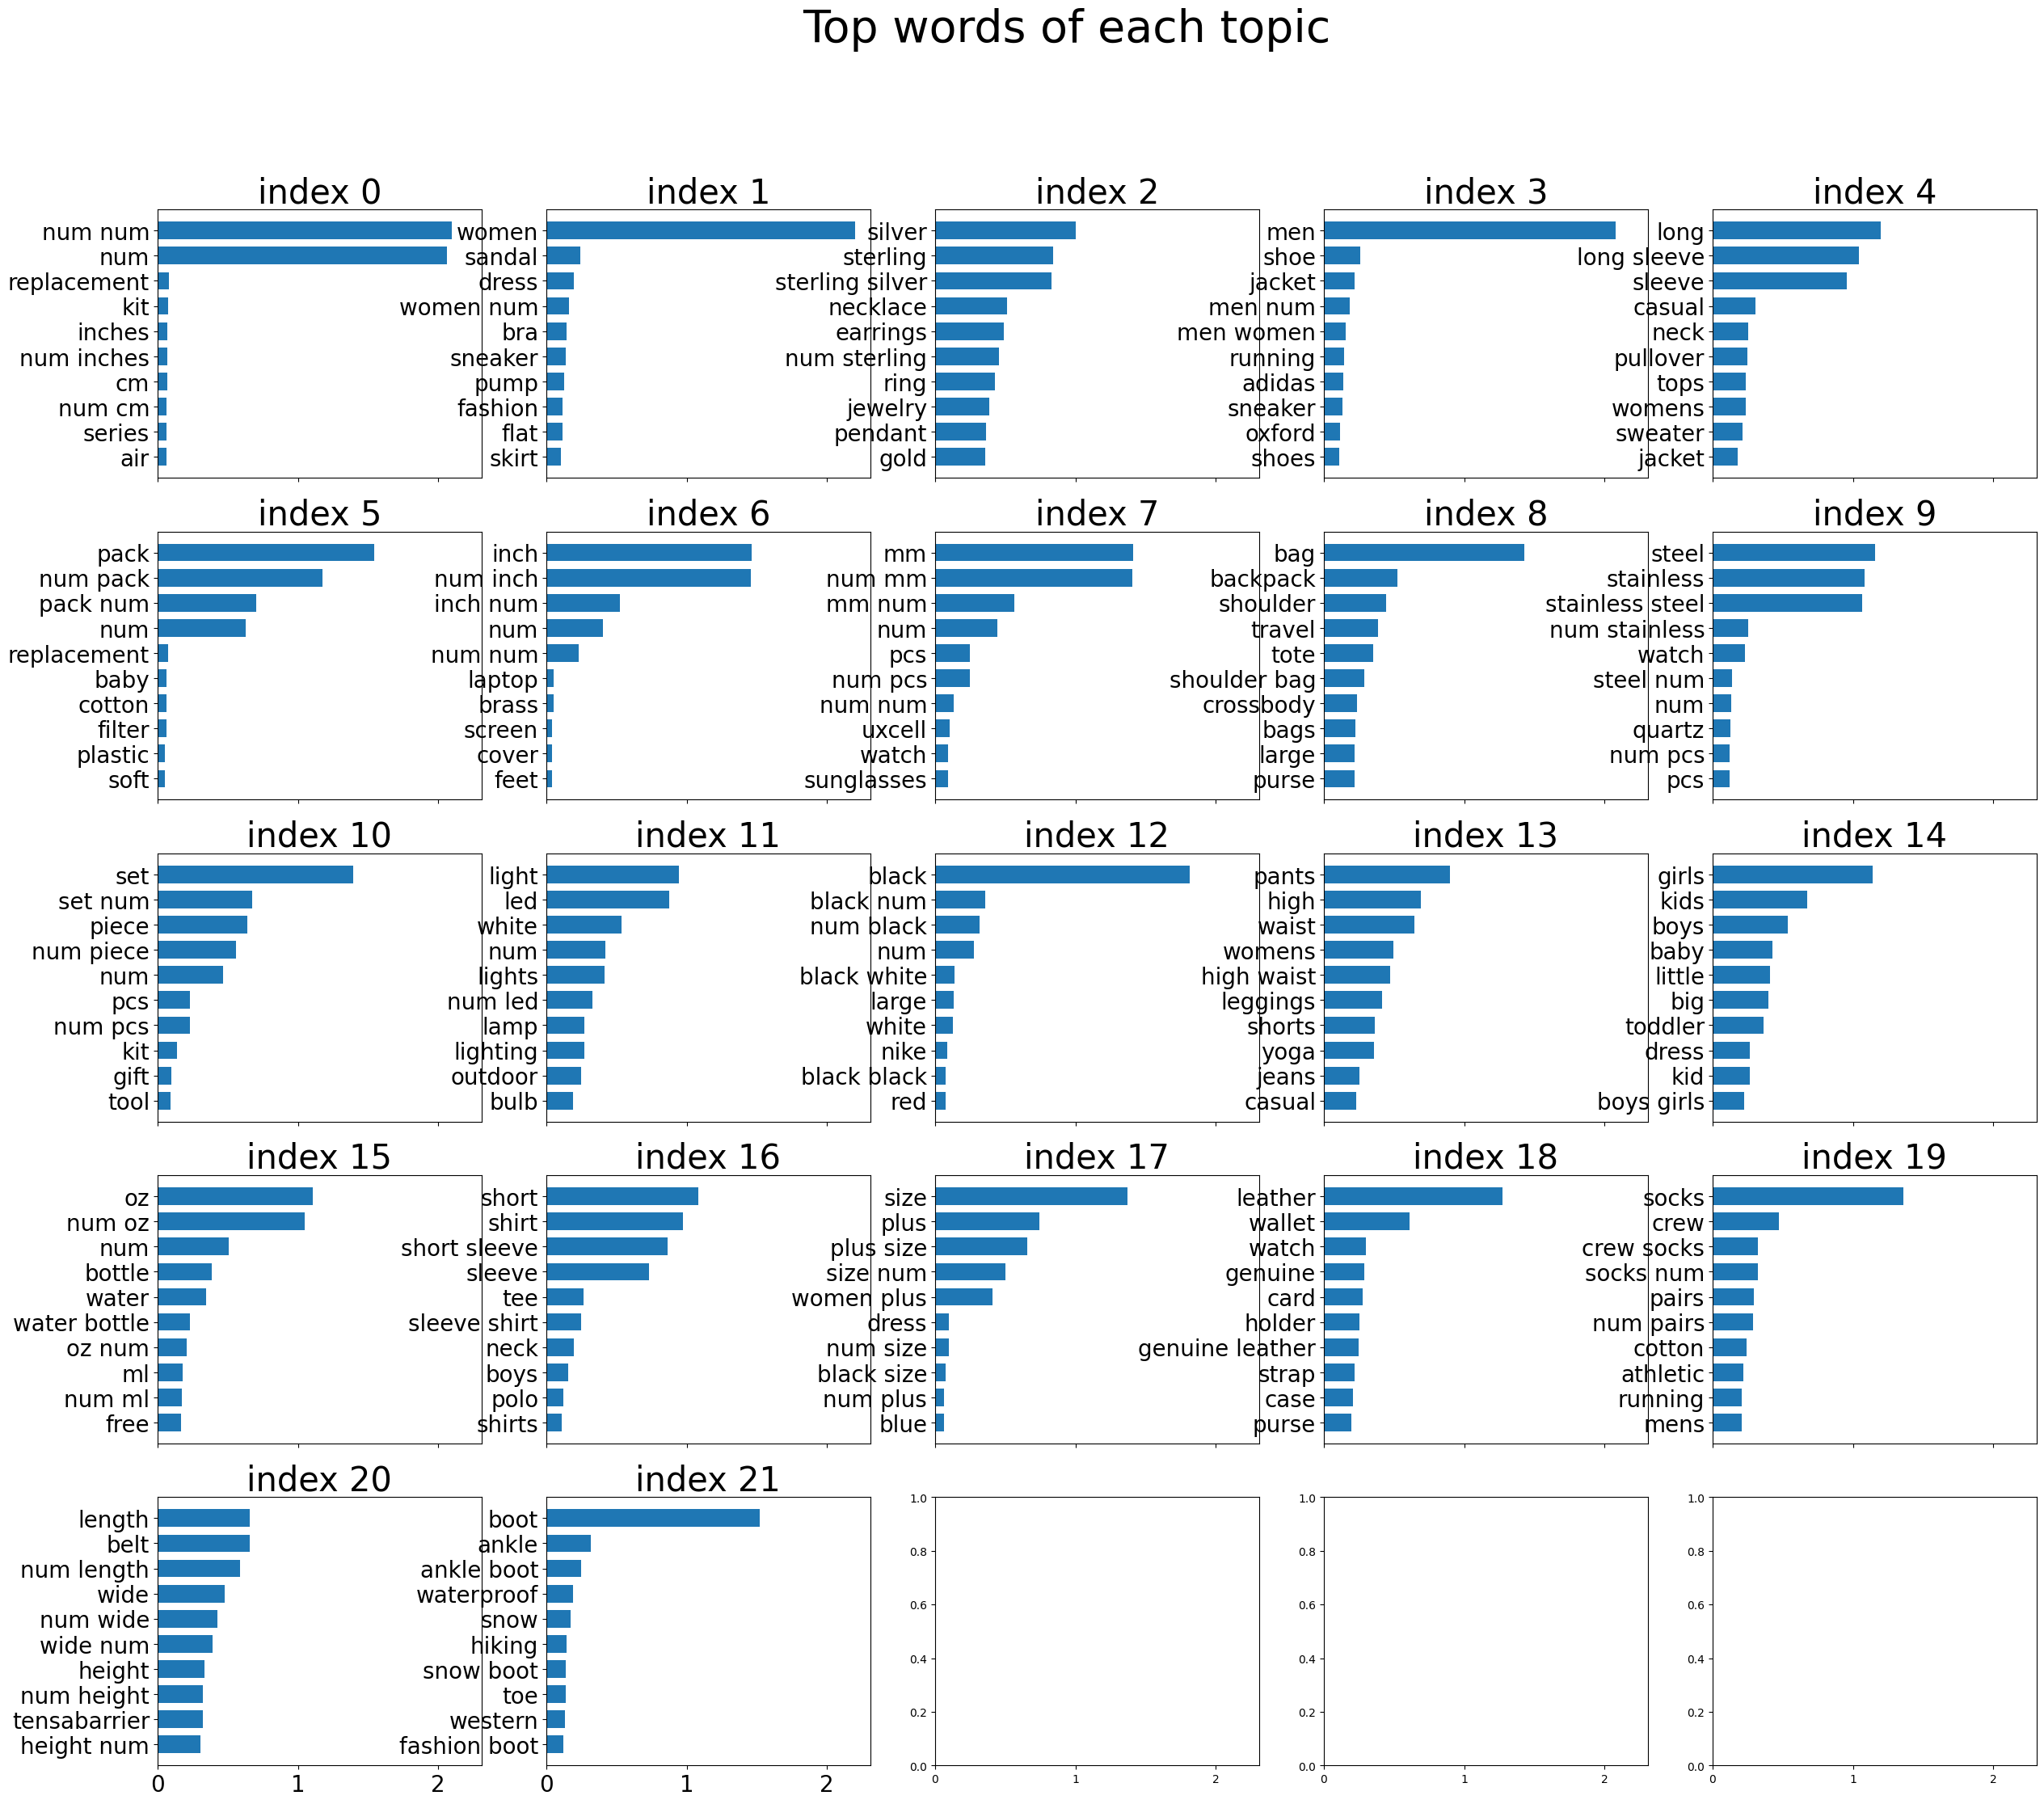

In [15]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

def plot_top_words(H, feature_names, n_top_words):
    title = 'Top words of each topic'
    fig, axes = plt.subplots(5, 5, figsize=(30, 25), sharex=True)
    for topic_idx, topic in enumerate(H):
        axes = axes.flatten()
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"index {topic_idx}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        fig.suptitle(title, fontsize=40)

print('Main categories:', pd.unique(amz.df_cat['main']))
plot_top_words(H, ftr_names, 10)

In [16]:
# The label_permute_compare -function below was taken from my Week 2 peer review.

import itertools
from sklearn.metrics import ConfusionMatrixDisplay


def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # your code here
    labels = np.unique(ytdf)
    #print(ytdf.info())
    #print(labels)
    acc = []
    labelorders = list(itertools.permutations(np.unique(yp)))
    for labelorder in labelorders:
        map_labels = [labels[mp] for mp in labelorder]
        #print(map_labels)
        yp_labels = [map_labels[yp[i]] for i in range(len(yp))]
        # ytdf['yp_labels'] = yp_labels
        acc.append(sum(ytdf==yp_labels)/len(yp_labels))
    i_max = np.argmax(acc)
    
    return labelorders[i_max], acc[i_max]

def reorder_prediction(yp):
    # Remap the predicted labels
    ypp = [label_order[y] for y in yp]
    return ypp

yp = np.argmax(W,axis=1)
print('yp length:',len(yp))
label_order, best_accu = label_permute_compare(Y_train, yp)
print('\nLabel order:', ' --> '.join([str(lbl) for lbl in label_order]))
print('\nAccuracy:', round(best_accu,4))

ypp = reorder_prediction(yp)
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(Y_train, ypp, ax=ax)
plt.show()

# Yhat_train = [df_cat_mapper.iloc[i,0] for i in ypp]

yp length: 3000397


MemoryError: 

## Comparison with supervised methods

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

print('mat.shape:', mat.shape, '\nY_train.shape:', Y_train.shape)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(mat, Y_train, test_size=0.2, random_state=123)

mat.shape: (3000397, 10000) 
Y_train.shape: (3000397,)


In [ ]:
from sklearn.svm import SVC

print('\nTry Radial Basis Function kernel:')
SVC_grid_paras = {'C':np.logspace(-5, 5, num=11 , base=2), 'gamma':np.logspace(-5, 5, num=11 , base=2)}
my_SVC_grid = GridSearchCV(estimator=SVC(), param_grid=SVC_grid_paras, scoring=None, n_jobs=None, refit=True, cv=5, verbose=0, pre_dispatch='2*n_jobs', return_train_score=True)
my_SVC_grid = my_SVC_grid.fit(X_train_clf, y_train_clf) # Create the model
print('Best parameters:', my_SVC_grid.best_params_)
print('Validation accuracy:', my_SVC_grid.best_score_)
my_SVC = my_SVC_grid.best_estimator_ # Save the best model
y_hat_SVC = my_SVC.predict(X_test_clf)
# calc_metrics(y_test_clf, y_hat_SVC) # calculate metrics


Try Radial Basis Function kernel:


In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_grid_paras = {'n_estimators': [10,100,500], 'min_samples_split': [2,3,4], 'min_samples_leaf': [1,2,3]}
my_RF_grid = GridSearchCV(RandomForestClassifier(), param_grid=RF_grid_paras, scoring=None, n_jobs=None, refit=True, cv=5, verbose=0, pre_dispatch='2*n_jobs', return_train_score=True)
my_RF_grid = my_RF_grid.fit(X_train_clf, y_train_clf) # Create the model
print('Best parameters:', my_RF_grid.best_params_)
print('Validation accuracy:', my_RF_grid.best_score_)
my_RF = my_RF_grid.best_estimator_ # Save the best model
y_hat_RF = my_RF.predict(X_test_clf)
# calc_metrics(y_test_clf, y_hat_SVC) # calculate metrics


## Discussion and conclusion ##


### Training time ###


### Additional improvements

